In [1]:
# initialize the environment
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import os

In [2]:
# Load data
df = pd.read_csv("../data/SPY.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
Price = df.loc[:,"Adj Close"]
Price = Price.loc[(Price.index>"2015-12-01") & (Price.index<"2018-01-25")]

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
# utility
def compute_ema(series=Price, short_window=5):
    return series.ewm(span=short_window,adjust=False).mean()
def compute_bollinger_band(series=Price, long_window=20, num_std=1):
    bollinger_band_middle = series.rolling(window = long_window).mean()
    rolling_std = series.rolling(window = long_window).std()
    bollinger_band_upper = bollinger_band_middle+rolling_std*num_std
    bollinger_band_lower = bollinger_band_middle-rolling_std*num_std
    return bollinger_band_upper,bollinger_band_middle, bollinger_band_lower
def ema_boll_strategy(series=Price, short_window=5, long_window=20, num_std=1,market_regime=1):
    ema = compute_ema(series, short_window)
    bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, long_window, num_std)
    position = pd.Series(None,index = series.index)
    mask_up_open = ema>=bb_upper
    position.loc[mask_up_open] = market_regime
    mask_down_open = ema<=bb_lower
    position.loc[mask_down_open] = -market_regime
    mask_close = ( (ema.shift()>=bb_middle.shift())&(ema<bb_middle) )|( (ema.shift()<=bb_middle.shift())&(ema>bb_middle) )
    position.loc[mask_close] = 0
    position.fillna(method="ffill",inplace=True)
    position.fillna(0,inplace=True)
    return position.astype(np.int)
def compute_PNL(price, position, reinvest = False):
    return_rate = price.shift(-1)/price - 1
    if reinvest:
        wealth_change = (1+position*return_rate)
        PNL = wealth_change.cumprod()
    else:
        PNL = (position*return_rate).cumsum()
    return PNL

# Micro Regime Detection

* **Background:** For a single-asset trading strategy, there are two prevailing assumptions mean-reversion or momentum, which can cover a large parts. Its performance depends on whether its assumed regime match the market regime.          

* **Our Goal:** Build a "smart" trading strategy that automatically switchs between mean-reversion and momentum according to market change.

* A example:

In [5]:
start_date = "2016-01-25"
short_window = 5
long_window = 19
num_std = 0.8

important_dates_ = ["2016-02-27","2016-04-20","2016-07-01","2016-11-15","2017-03-06","2017-09-05"]

position = ema_boll_strategy(series=Price, short_window=5, long_window=20, num_std=1,market_regime=1)

benchmark_return = (Price.shift(-1)/Price - 1)
benchmark_return = benchmark_return[benchmark_return.index>start_date]
benchmark_return.iloc[0] = 0
benchmark = (benchmark_return.cumsum() +1)*1e6

back_test_cum_return = compute_PNL(Price,position)
back_test_cum_return  = back_test_cum_return[back_test_cum_return.index>start_date]
back_test_cum_return .iloc[0] = 0
back_test = (1+back_test_cum_return)*1e6

back_test_return = back_test_cum_return.diff().fillna(0)
switch = pd.Series(1,index =back_test_return.index,dtype=int)
switch.loc[switch.index<important_dates_[0]] = -1
switch.loc[(switch.index>important_dates_[1]) & (switch.index<important_dates_[2])] = -1
switch.loc[(switch.index>important_dates_[2]) & (switch.index<important_dates_[3])] = 0
switch.loc[(switch.index>important_dates_[4]) & (switch.index<important_dates_[5])] = -1
back_test_switched = ((back_test_return*switch).cumsum() +1)*1e6


fig, ax = plt.subplots(figsize = (15,9))
ax.plot(back_test,"b",label="trading strategy")
ax.plot(back_test_switched,"g-.",label="trading strategy(swithed)")
#ax.plot(benchmark,"g",label="benchmark(SPY)")
ax.axis(ymin=9e5, ymax=15e5)
ax.legend()
ax.set_title("cumulative PNL")

important_dates = [pd.to_datetime(date) for date in important_dates_]
y_ = 1e6*np.arange(0.5,2.0+1e-6,0.4) 
for date in important_dates:
    ax.plot([date]*len(y_),y_,'r-.')

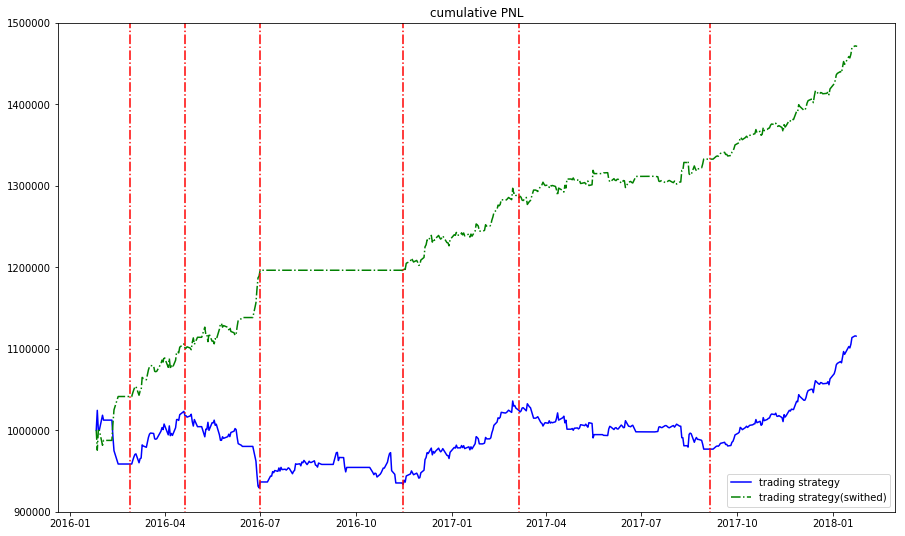

In [6]:
plt.show()

## Basic Idea

* **Label the data** : Build Measure for Market Regime (Mean-Reversion / Momentum) [What to switch!]
> Sub-Problem: Find the most valuable trading strategies to switch beween!
* **Train the model** : Build Indicator for Market Regime [When to switch!]

$$$$

## Build Measure for Market Regime (Mean-Reversion / Momentum)

### How to describe the Market Regime for a specific price series?
 * By manually picking? --- NO!
 * We need a quantitative measure
 * However, the Market Regime can be different for different time scale!

### Use PNL output of trading strategies to measure Market Regime

two **mutually exclusive** EMA(Exponential moving average)-BollingerBands strategies
EMA (short_window) and BollingerBands (long_window, num_std)

**Momentum**:  
 * Long if EMA crosses over Upper Band; close if EMA crosses down below Middle Band       
 * Short if EMA crosses down below Upper Band; close if EMA crosses from below Middle Band           
                   
**Mean-reversion**:              
 * Long if EMA crosses over Upper Band; close if EMA crosses down below Middle Band       
 * Short if EMA crosses down below Upper Band; close if EMA crosses from below Middle Band    

<table>
        <tr>
            <th><center>Momentum</center></th>
            <th><center>Mean-reversion</center></th>
        </tr>
        <tr>
            <th><img src=pic/momentum.png width=840></th>
            <th><img src=pic/mean-reversion2.jpeg width=700></th>
        </tr>
    </table>



### Parameters for Market Regime Measure
 * Different (long_window, short_window, num_std) stands for different scale of Market Regime
 * How to select parameters?
 * Remember the partially flipped curve?

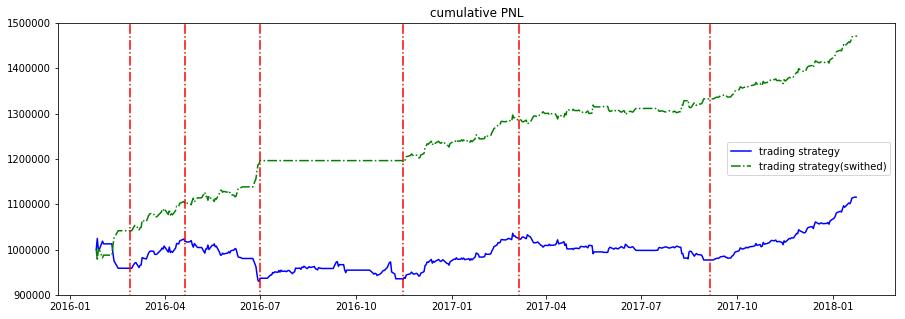

In [7]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(back_test,"b",label="trading strategy")
ax.plot(back_test_switched,"g-.",label="trading strategy(swithed)")
#ax.plot(benchmark,"g",label="benchmark(SPY)")
ax.axis(ymin=9e5, ymax=15e5)
ax.legend()
ax.set_title("cumulative PNL")


important_dates = [pd.to_datetime(date) for date in important_dates_]
y_ = 1e6*np.arange(0.5,2.0+1e-6,0.4) 
for date in important_dates:
    ax.plot([date]*len(y_),y_,'r-.')
plt.show()

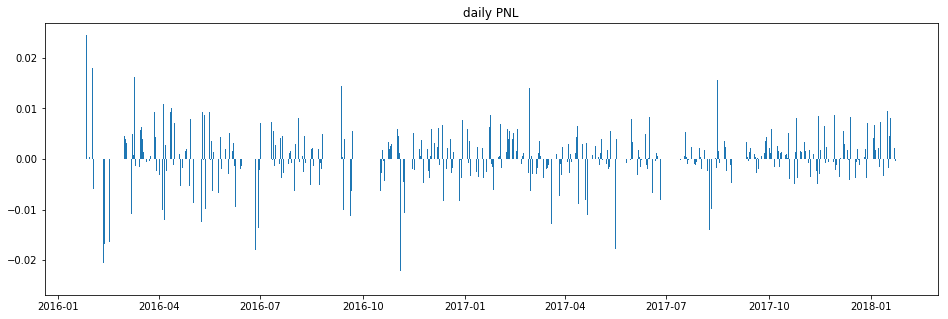

In [8]:
fig, ax = plt.subplots(figsize = (16,5))
ax.bar(back_test_return.index,back_test_return)
ax.set_title("daily PNL")
#ax.bar(back_test_return.index,np.sign(back_test_return))
#ax.set_title("Sign of daily PNL")
plt.show()

We expect to observe this pattern: (with potential to be flipped)

In [9]:
rand = np.random.RandomState(seed=11086220)
daily_PNL = np.zeros(200)
for i in range(200):
    if (i//40)%2 == 0:
        daily_PNL[i] = 0.05 * rand.rand() + 0.02 * (rand.rand()-0.5) 
    else:
        daily_PNL[i] = -0.05 * rand.rand() + 0.02 * (rand.rand() -0.5)
    if i%4 == 0: 
        daily_PNL[i] += - np.sign(daily_PNL[i]) * (rand.rand())*0.05
    if i%7 == 0: 
        daily_PNL[i] += - np.sign(daily_PNL[i]) * (rand.rand())*0.05
        
fig, axs = plt.subplots(2,1,figsize = (16,10))
axs[0].set_title("daily PNL")
axs[0].bar(np.arange(len(daily_PNL)),daily_PNL)
for x in range(40,200,40):
    axs[0].plot([x]*len(y_),y_,'r-.')
axs[0].axis(ymax = 0.07,ymin=-0.05)
y_ = [-10,10] 
for x in range(40,200,40):
    axs[1].plot([x]*len(y_),y_,'r-.')
axs[1].axis(ymax = 1.2,ymin=-0.2)
axs[1].set_title("cumulative PNL")
axs[1].plot(np.r_[[0],np.cumsum(daily_PNL)])

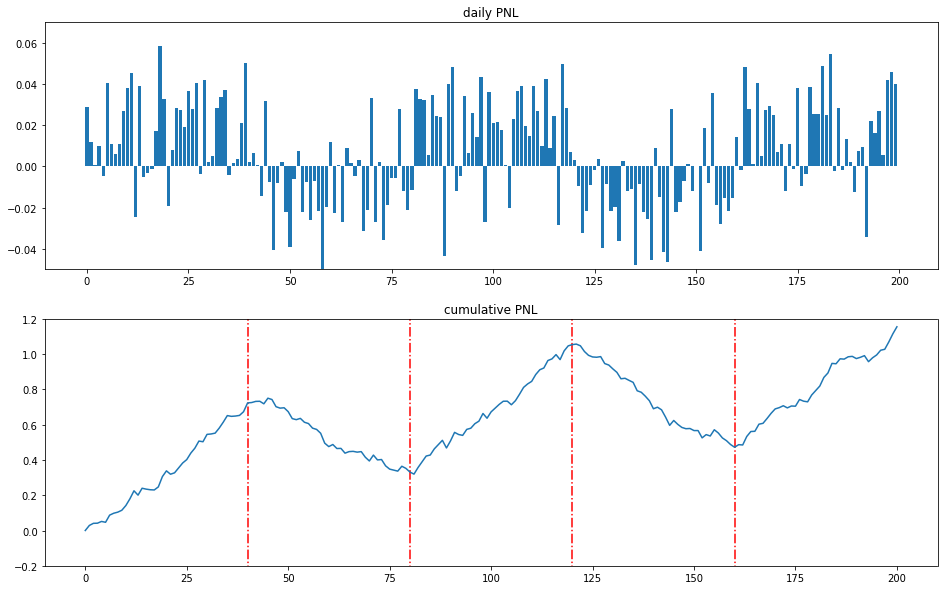

In [10]:
plt.show()

* A further problem is how to measure this "zigzag" pattern!    
* If we can select parameters for this "zigzag" pattern, we can that claim the strategy with these parameters is more valuable to switch between different market regime and achieve bettter performance!
* A naive idea is 
$$\frac{mean(|MA(r)|)}{mean(MA(|r|))  }$$


while $r$ is daily PNL

In [11]:
r = np.zeros(200)
plt.figure(figsize=(16,10))
for k in range(1,12,2):
    for i in range(200):
        if (i//40)%2 == 0:
            r[i] = 0.02 * np.random.rand() + k*0.02 * (np.random.rand()-0.5) 
        else:
            r[i] = -0.02 * np.random.rand() + k*0.02 * (np.random.rand() -0.5)
        if (i//40)%6 == 0: 
            r[i] += (np.random.rand() -0.5)*0.05*k
    if k == 9:
        r = (0.015 * (np.random.rand(200))) + (np.random.rand(200)-0.5)*0.05
    if k == 11:
        r = np.diff((0.07* (np.random.rand(200))))
    r = pd.Series(r)
    f1 = r.abs().mean()*1e3
    f2 = r.rolling(window=5).mean().abs().mean()*1e3
    f3 = r.abs().rolling(window=5).mean().mean()*1e3
    
    plt.plot(r.cumsum(),label=(f2/f3))
plt.legend()


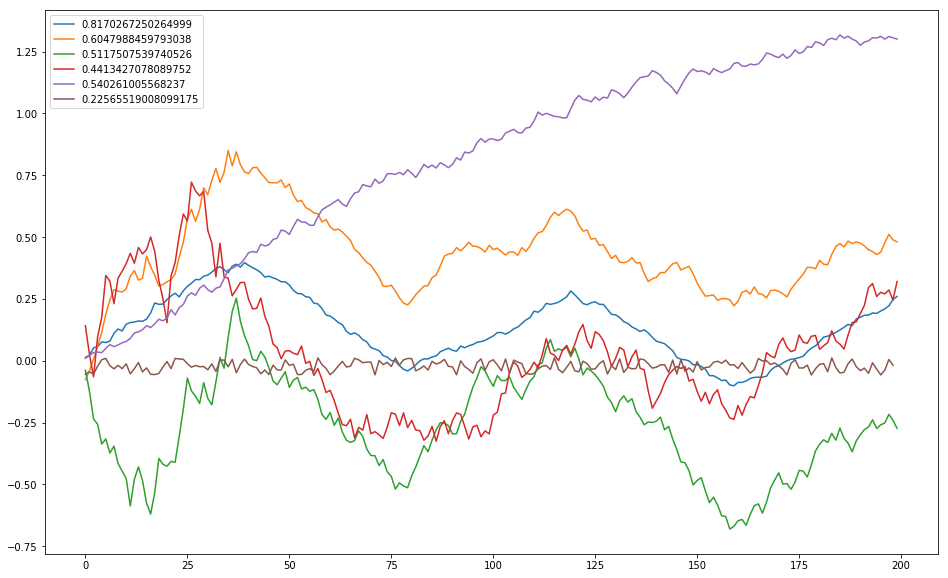

In [14]:
plt.show()

### Extension - multiple choice of non-opposite path

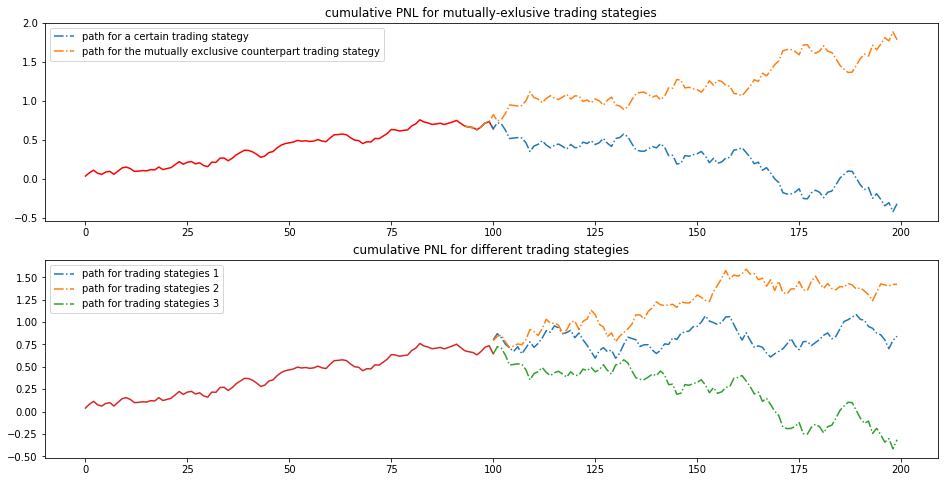

In [21]:
x = np.arange(200)
fig, axs= plt.subplots(2,1,figsize=(16,8))
path = np.zeros(200)
path[:100]= (np.random.rand(100)-0.4)*0.1
for i in range(3):
    path[100:] = (np.random.rand(100)-0.5)*0.2
    if i ==1:
        path[100:] += (np.random.rand(100)-0.4)*0.08
    if i ==2:
        path[100:] += (np.random.rand(100)-0.7)*0.08
    axs[1].plot(x[100:],path.cumsum()[100:],"-.",label="path for trading stategies "+str(i+1))
    
axs[1].plot(x[:101],path[:101].cumsum())
axs[1].legend()
axs[1].set_title("cumulative PNL for different trading stategies")

axs[0].plot()
axs[0].plot(x[:101],path[:101].cumsum(),"r")
axs[0].plot(x[93:],path.cumsum()[93:],"-.",label="path for a certain trading stategy")
path[100:] = -path[100:]
axs[0].plot(x[93:],path.cumsum()[93:],"-.",label="path for the mutually exclusive counterpart trading stategy")
axs[0].set_title("cumulative PNL for mutually-exlusive trading stategies")
axs[0].legend()
plt.show()

Non-exclusive strategy:

Momentum(ma_window):
* Long if asset crosses over ma_window-bar moving average, close if asset crosses under ma_window-bar moving average       
* Short if asset crosses down below ma_window-bar moving average, close if asset crosses from below ma_window-bar moving average        
     
Mean-reversion(bb_windown,num_std):        
* Short  if asset crosses over Upper Band, close if asset crosses under Middle Band       
* Long if asset crosses down Lower Band, close if asset crosses from below Middle Band                

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

In [ ]:
# Load data
df = pd.read_csv("../data/SPY_.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
Price = df.loc[:,"Adj Close"]

In [ ]:
def divide_period(window_length = 63, series = Price):
    """
    return the vector that divides the series into windows of fixed size
    """

    # define number of windows
    num_windows = len(series) // window_length

    # divide the Price into num_windows
    window_index = np.arange(0,(1+num_windows)*window_length,window_length)
    return window_index

In [ ]:
# find the date
window_index = divide_period(window_length = 63, series = Price)
price_index = Price.index[window_index[1:]]

In [ ]:
# compute_ema (the middle band)
def compute_ema(series=Price, short_window=5):
    return series.ewm(span=short_window,adjust=False).mean()

In [ ]:
# compute the bollinger_band
def compute_bollinger_band(series=Price, span=20, num_std=1.2):
    bollinger_band_middle = Price.ewm(span=span).mean()
    rolling_std = Price.ewm(com=9.5).std()
    bollinger_band_upper = bollinger_band_middle+rolling_std*num_std
    bollinger_band_lower = bollinger_band_middle-rolling_std*num_std
    return bollinger_band_upper,bollinger_band_middle, bollinger_band_lower

In [ ]:
def momentum_strategy(series=Price, long_window=20, short_window = 5, num_std=0.1, market_regime=1, window_length = 63):
    """
    for each period, check if momentum strategy's PNL is + or -
    return a nx1 vector Of gain or loss
    """
    # EMA indicator
    bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, long_window, num_std)
    
    # periods

    window_index = divide_period(window_length = window_length, series = series[1:])
    
    # result vector
    res = np.zeros(len(window_index) - 1)
    
    # trade count
    trade_count = np.zeros(len(window_index) - 1)
    
    # momentum strategy
    # for every periods
    for i in range(len(window_index)-1):
        current_price = series[window_index[i]:window_index[i+1]]
        current_period = series.ewm(span=short_window,adjust=False).mean()[window_index[i]:window_index[i+1]]
        current_upper = bb_upper[window_index[i]:window_index[i+1]]
        current_middle = bb_middle[window_index[i]:window_index[i+1]]
        current_lower = bb_lower[window_index[i]:window_index[i+1]]
        
        # notice the the indicators are designed such that there is no chance of them overlap
        # price cross middle from below
        long_indicator = np.all([current_period > current_upper, current_period.shift(1) < current_upper.shift(1)], axis=0)
        
        # price cross middle from above
        close_long_indicator = np.all([current_period < current_middle, current_period.shift(1) > current_middle.shift(1)], axis=0)
    
        # price cross lower from above
        short_indicator = np.all([current_period < current_lower, current_period.shift(1) > current_lower.shift(1)], axis=0)
        
        # price cross middle from below
        close_short_indicator = np.all([current_period > current_middle, current_period.shift(1) < current_middle.shift(1)], axis=0)
        
        
        
        
        # make the strategy
        # if eixst position, close it anyway at end of the period
        position = 0
        pnl = 0
        pre_price = 0
        count = 0
        
        for j in range(window_length):

            # long indicator is activated
            if long_indicator[j] == True and position == 0:
                position = 1
                pre_price = current_price[j]
                
            # close long indicator is activated
            if close_long_indicator[j] == True and position == 1:
                position = 0
                pnl += current_price[j] - pre_price
                pre_price = 0
                count += 1
            
            # short indicator is activated
            if short_indicator[j] == True and position == 0:
                position = -1
                pre_price = current_price[j]
            
            # close short indicator is activated
            if close_short_indicator[j] == True and position == -1:
                position = 0
                pnl += pre_price - current_price[j]
                pre_price = 0
                count += 1
                
        # close any existing position
        if position != 0:
            if position == 1:
                pnl += current_price[window_length-1] - pre_price
            if position == -1:
                pnl += pre_price - current_price[window_length-1]
                
        res[i] = pnl 
        trade_count[i] = count
        
    return res, trade_count

In [ ]:
def mean_reversion_strategy(series=Price, long_window=20, num_std=1.2, market_regime=1, window_length = 63):
    """
    for each period, check if mean reversion strategy's PNL is + or -
    return a nx1 vector Of gain or loss
    """
    # EMA indicator
    bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, long_window, num_std)
    
    # periods
    window_index = divide_period(window_length = window_length, series = series[1:])
    
    # result vector
    res = np.zeros(len(window_index) - 1)
    
    # trade count
    trade_count = np.zeros(len(window_index) - 1)
    
    # mean reversion strategy
    # for every periods
    """
    a=b=c=d=[]
    e=f=g=h=[]
    """ 
    
    for i in range(len(window_index)-1):

        current_period = series[window_index[i]:window_index[i+1]]
        current_upper = bb_upper[window_index[i]:window_index[i+1]]
        current_middle = bb_middle[window_index[i]:window_index[i+1]]
        current_lower = bb_lower[window_index[i]:window_index[i+1]]
        
        # notice the the indicators are designed such that there is no chance of them overlap
        # price cross lower from above
        long_indicator = np.all([current_period < current_lower, current_period.shift(1) > current_lower.shift(1)], axis=0)
        
        # price cross middle from below
        close_long_indicator = np.all([current_period > current_middle, current_period.shift(1) < current_middle.shift(1)], axis=0)
    
        # price cross middle from above
        close_short_indicator = np.all([current_period < current_middle, current_period.shift(1) > current_middle.shift(1)], axis=0)
        
        # price cross upper from below
        short_indicator = np.all([current_period > current_upper, current_period.shift(1) < current_upper.shift(1)], axis=0)
        
        
        ############
        """
        if i == 1:
            a=current_period
            b=current_upper
            c=current_middle
            d=current_lower
            
            e=long_indicator
            f=close_long_indicator
            g=close_short_indicator
            h=short_indicator
        """    
        ############
        # make the strategy
        # if eixst position, close it anyway at end of the period
        position = 0
        pnl = 0
        pre_price = 0
        count = 0
        for j in range(window_length):
                
            # long indicator is activated
            if long_indicator[j] == True and position == 0:
                position = 1
                pre_price = current_period[j]
                
            # close long indicator is activated
            if close_long_indicator[j] == True and position == 1:
                position = 0
                pnl += current_period[j] - pre_price
                pre_price = 0
                count += 1
            
            # short indicator is activated
            if short_indicator[j] == True and position == 0:
                position =  -1
                pre_price = current_period[j]
            
            # close short indicator is activated
            if close_short_indicator[j] == True and position == -1:
                position = 0
                pnl += pre_price - current_period[j]
                pre_price = 0
                count += 1
                
        # close any existing position
        if position != 0:
            if position == 1:
                pnl += current_period[window_length-1] - pre_price
            if position == -1:
                pnl += pre_price - current_period[window_length-1]
                
        res[i] = pnl 
        trade_count[i] = count
        
    return res, trade_count

# character the market regime from 63 days window
plots shows the distribution of window pnl and number of transactions 

In [ ]:
from matplotlib.ticker import *

fig, axs = plt.subplots(1,2,figsize=(16,9))
return_MR, trade_count_MR=mean_reversion_strategy();
return_MO, trade_count_MO=momentum_strategy();

axs[0].hist(return_MR, bins=20)
axs[0].set_title("Mean-Reversion")
axs[1].hist(return_MO, bins=20)
axs[1].set_title("Momentum")
plt.show()

In [ ]:
MR_series = pd.DataFrame({'trasanction':trade_count_MR, 'time':price_index.values,'return':return_MR})
MR_series = MR_series.set_index("time")
MO_series = pd.DataFrame({'trasanction':trade_count_MO, 'time':price_index.values, 'return':return_MO})
MO_series = MO_series.set_index("time")
MR_series.plot.bar(subplots=True, figsize=(12,8))
plt.show()

In [ ]:
MO_series.plot.bar(subplots=True, figsize=(12,8))
plt.show()

In [ ]:
"""
from matplotlib.ticker import *

fig, axs = plt.subplots(3,1,figsize=(12,20))
return_MR, trade_count_MR=mean_reversion_strategy();
axs[0].hist(return_MR, bins=20);
MR_series = pd.DataFrame({'trasanction':trade_count_MR, 'time':price_index.values,'return':return_MR})

MR_series = MR_series.set_index("time")
axs[1].bar(MR_series.index,MR_series.loc[:,"return"])

axs[2].bar(MR_series.index,MR_series.trasanction)
"""

In [ ]:
b_return_MR = np.where(return_MR>0, 1, 0)

In [ ]:
b_return_MO = np.where(return_MO>0, 1, 0)

In [ ]:
regime = list(zip(b_return_MR,b_return_MO ))

In [ ]:
r1 = (0,0)
r2 = (0,1)
r3 = (1,0)
r4 = (1,1)
regime_indicator = np.empty_like(b_return_MO)
for i in range(len(regime)):
    if regime[i] == r1:
        regime_indicator[i] = 0
    elif regime[i] == r2:
        regime_indicator[i] = 1
    elif regime[i] == r3:
        regime_indicator[i] = 2
    elif regime[i] == r4:
        regime_indicator[i] = 3
regime_df = pd.DataFrame({'frame':regime_indicator, 'time':MO_series.index.values}) 
regime_df.set_index("time");

# regime from window_size = 63 and std = 1.2
3 means both mean reversion and momentum

2 means mean reversion

1 means momentum

0 mean neither

In [ ]:
plt.figure(figsize=(12,5))
plt.plot_date(MO_series.index,regime_indicator, '+');

# find the window_size and std to maximize variance

In [ ]:
# investigate the impact of window size
def find_window(start = 20, end = 80):
    """
    return: 
    an array of correlation between mean-reversion and momentum
    """
    corr_array = np.zeros(end-start)
    window_size_array = np.arange(start,end,1)
    for i in range(len(window_size_array)):
        return_MO, trade_count_MR=momentum_strategy(window_length=window_size_array[i]);
        return_MR, trade_count_MR=mean_reversion_strategy(window_length=window_size_array[i]);
        # convert into binary
        b_return_MR = np.where(return_MR>0, 1, 0)
        b_return_MO = np.where(return_MO>0, 1, 0)
        corr_array[i] = np.corrcoef(b_return_MR,b_return_MO)[1][0]
        
    return  corr_array,  window_size_array

In [ ]:
corr_array,  window_size_array = find_window()

In [ ]:
plt.figure(figsize=(12,10));
plt.plot(window_size_array, corr_array);
plt.xlabel('window_size')
plt.ylabel('correlation')

In [ ]:
def find_paras(window=(50,80), std = (0.8, 2.1)):
    """
    return: 
    a matrix of correlation between mean-reversion and momentum
    """
    corr_array = np.zeros((window[1]-window[0], int((std[1]-std[0])/0.1)))
    
    window_size_array = np.arange(window[0],window[1],1)
    
    std_array = np.arange(std[0], std[1], 0.1)
    for i in range(len(window_size_array)):
        for j in range(len(std_array)):
            return_MO, trade_count_MR=momentum_strategy(window_length=window_size_array[i]);
            return_MR, trade_count_MR=mean_reversion_strategy(window_length=window_size_array[i], num_std=std_array[j]);
            # convert into binary
            b_return_MR = np.where(return_MR>0, 1, 0)
            b_return_MO = np.where(return_MO>0, 1, 0)
            corr_array[i,j] = np.corrcoef(b_return_MR,b_return_MO)[1][0]

    return  corr_array,  window_size_array, std_array

In [ ]:
corr_array,  window_size_array, std_array = find_paras()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
window_size_array, std_array = np.meshgrid(window_size_array, std_array)

ax = plt.axes(projection='3d')
ax.plot_surface(window_size_array, std_array, corr_array.T, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');

# possible best params [window_size = 76 and std = 0.8]

3 means both mean reversion and momentum

2 means mean reversion

1 means momentum

0 mean neither

In [ ]:
return_MO, trade_count_MR=momentum_strategy(window_length=76);
return_MR, trade_count_MR=mean_reversion_strategy(window_length=76, num_std=0.8);
b_return_MR = np.where(return_MR>0, 1, 0)
b_return_MO = np.where(return_MO>0, 1, 0)
np.corrcoef(b_return_MR,b_return_MO)[1][0]

In [ ]:
regime = list(zip(b_return_MR,b_return_MO ))
r1 = (0,0)
r2 = (0,1)
r3 = (1,0)
r4 = (1,1)
regime_indicator = np.empty_like(b_return_MO)
for i in range(len(regime)):
    if regime[i] == r1:
        regime_indicator[i] = 0
    elif regime[i] == r2:
        regime_indicator[i] = 1
    elif regime[i] == r3:
        regime_indicator[i] = 2
    elif regime[i] == r4:
        regime_indicator[i] = 3
plt.plot(regime_indicator,'+')
plt.show()

## Build Indicator for Market Regime

Now It's time to train our model to learn from time series input.

First, we can use following technical index as indicator

 * **Hurst Exponent** : a measure of long-term memory of time series related to the autocorrelations                 
 * **Long short scale volatility ratio** : long-scale volatility / short-scale volatility        
 * **Autocorrelations**: Autocorrelations for different lag  
 * **Sharp Ratio**: inverse of Coefficient of variation
 * **PVT**: Price volume trend ( $MA(return \times volume)$ )
 * **Volume**

In [15]:
def compute_hurst_exponent(arr):
    log_arr = np.log(arr)
    num_lag = 18
    lag_arr = np.arange(2,2+num_lag)
    tau_arr = np.zeros(num_lag)
    #  Step through the different lags
    for i in range(num_lag):
        lag = lag_arr[i]
        #  produce return difference with lag
        arr_diff = np.diff(log_arr,lag)
        #  Calculate the variance of the differnce vector
        tau_arr[i] = np.sqrt(np.std(arr_diff))
    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lag_arr),np.log10(tau_arr),1)
    # calculate hurst
    hurst = m[0]*2.
    return hurst
def compute_vol(arr):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    vol = np.float(np.sqrt(np.cov(return_arr)))
    return vol
def compute_long_short_scale_vol_ratio(arr, long_scale ,short_scale=1):
    arr_long_scale = arr[::long_scale]
    arr_short_scale = arr[::short_scale]
    
    return compute_vol(arr_short_scale)/compute_vol(arr_long_scale)
def compute_autocorr(arr, lag):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    mat_autocov = np.cov(return_arr[lag:],return_arr[:-lag])
    autocorr = mat_autocov[1,0]/np.sqrt(mat_autocov[0,0]*mat_autocov[1,1])
    return autocorr
def compute_sharpe(arr):
    ret = np.divide(np.diff(arr),arr[:-1])
    return(np.std(ret)/np.mean(ret))

In [16]:
# Load data
df = pd.read_csv("../data/SPY.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
Price = df.loc[:,"Adj Close"]
Volume = df.loc[:,"Volume"]

In [17]:
window_indicators = 30
Indicators = pd.DataFrame(index = Price.index, columns=["hurst_exponent",
                                                        "long_short_scale_vol_ratio_2",
                                                        "long_short_scale_vol_ratio_3",
                                                        "long_short_scale_vol_ratio_4",
                                                        "long_short_scale_vol_ratio_5",
                                                        "autocorr_1",
                                                        "autocorr_2",
                                                        "autocorr_3",
                                                        "autocorr_4",
                                                        "autocorr_5",
                                                        "autocorr_6",
                                                        "autocorr_7",
                                                        "sharpe_ratio",
                                                        "PVT",
                                                        "Volume"])
Indicators.loc[:,"hurst_exponent"] = Price.rolling(window=window_indicators).apply(compute_hurst_exponent)
Indicators.loc[:,"long_short_scale_vol_ratio_2"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,2))
Indicators.loc[:,"long_short_scale_vol_ratio_3"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,3))
Indicators.loc[:,"long_short_scale_vol_ratio_4"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,4))
Indicators.loc[:,"long_short_scale_vol_ratio_5"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,5))
Indicators.loc[:,"autocorr_1"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,1))
Indicators.loc[:,"autocorr_2"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,2))
Indicators.loc[:,"autocorr_3"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,3))
Indicators.loc[:,"autocorr_4"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,4))
Indicators.loc[:,"autocorr_5"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,5))
Indicators.loc[:,"autocorr_6"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,6))
Indicators.loc[:,"autocorr_7"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,7))
Indicators.loc[:,"sharpe_ratio"] = Price.rolling(window=window_indicators).apply(compute_sharpe)
Indicators.loc[:,"PVT"] = ((Price/Price.diff()-1)*Volume/1e8).rolling(window=10).mean()
Indicators.loc[:,"Volume"] = Volume

In [18]:
short_window = 1
long_window = 28
num_std = 0.9
position = ema_boll_strategy(series=Price, short_window=5, long_window=20, num_std=1,market_regime=1)
daily_pnl = compute_PNL(Price,position).diff().fillna(0)

* We would first try linear model based on technical indicators with relatively strong correlation.
* Then try the linear combination and nonlinear model.

In [19]:
import seaborn as sns
# Indicators with lag 1
df = Indicators.shift()
# Build 3 measure for regime(positive is momentum, negtive is mean-reversion,
# the larger the number, the stronger the regime)
df = df.loc[back_test_return.index]
df.loc[:,"daily_PNL"] = daily_pnl
df.loc[:,"daily_PNL sign"] = daily_pnl.apply(np.sign)
df.loc[:,"daily_PNL moving average"] = daily_pnl.rolling(window=3).mean()

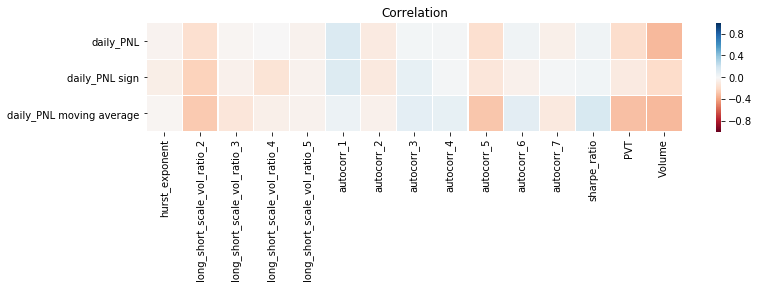

In [20]:

corr = df.loc["2015-01-01":"2016-07-01"].corr()
f, ax= plt.subplots(figsize = (12, 2))
sns.heatmap(corr.iloc[-3:,:-3], vmin=-1, vmax=1,cmap="RdBu", linewidths = 0.05, ax = ax)
ax.set_title("Correlation")
plt.show()